In [1]:
!pip install torch transformers scikit-learn --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.4 MB/s eta 0:00:00


In [2]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import classification_report

In [3]:
!git clone https://github.com/islnlp/Assignment_1_2025.git

Cloning into 'Assignment_1_2025'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 35 (delta 6), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (35/35), 1.06 MiB | 10.86 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [4]:
!pip install torch torchvision torchaudio --quiet
!pip install transformers --quiet
!pip install scikit-learn --quiet

# import all needed library
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW

# use cuda if have
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# function to load train and val for one task
def load_data(train_path, val_path):
    train_df = pd.read_csv(train_path)
    val_df = pd.read_csv(val_path)
    train_df = train_df.dropna()
    val_df = val_df.dropna()
    return train_df, val_df

# all dataset path
datasets = {
    'hate': {
        'train': '/content/Assignment_1_2025/hate/train.csv',
        'val': '/content/Assignment_1_2025/hate/val.csv'
    },
    'humor': {
        'train': '/content/Assignment_1_2025/humor/train.csv',
        'val': '/content/Assignment_1_2025/humor/val.csv'
    },
    'sarcasm': {
        'train': '/content/Assignment_1_2025/sarcasm/train.csv',
        'val': '/content/Assignment_1_2025/sarcasm/val.csv'
    }
}


In [6]:
# simple vocab build
from collections import Counter

def build_vocab(texts, min_freq=1):
    counter = Counter()
    for text in texts:
        counter.update(str(text).lower().split())
    vocab = {word: i+2 for i, (word, count) in enumerate(counter.items()) if count >= min_freq}
    vocab['<PAD>'] = 0
    vocab['<UNK>'] = 1
    return vocab

def encode(text, vocab):
    return [vocab.get(word, vocab['<UNK>']) for word in str(text).lower().split()]


In [7]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_len=50):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        tokens = encode(self.texts[idx], self.vocab)
        if len(tokens) < self.max_len:
            tokens += [0] * (self.max_len - len(tokens))
        else:
            tokens = tokens[:self.max_len]
        return torch.tensor(tokens), torch.tensor(self.labels[idx])

# for BERT
class BERTDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=64):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            str(self.texts[idx]), padding='max_length', truncation=True, max_length=self.max_len, return_tensors='pt')
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item


In [8]:
class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        _, h_n = self.rnn(x)
        out = self.fc(h_n.squeeze(0))
        return out

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        _, (h_n, _) = self.lstm(x)
        out = self.fc(h_n.squeeze(0))
        return out

class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)  # (batch, seq, embed)
        x = x.permute(1, 0, 2)  # (seq, batch, embed)
        x = self.transformer(x)
        out = self.fc(x[0])
        return out


In [9]:
def predict_rnn_lstm_transformer(sentence, task, model_type):
    # task: "hate", "humor", "sarcasm"
    # model_type: "rnn", "lstm", "transformer"
    le = get_label_encoder(task)
    vocab = get_vocab(task)
    num_classes = len(le.classes_)
    vocab_size = len(vocab)

    # choose model
    if model_type == "rnn":
        model = RNNClassifier(vocab_size, 128, 64, num_classes)
        weight_path = f"/content/{task}_rnn_weights.pth"
    elif model_type == "lstm":
        model = LSTMClassifier(vocab_size, 128, 64, num_classes)
        weight_path = f"/content/{task}_lstm_weights.pth"
    elif model_type == "transformer":
        model = TransformerClassifier(vocab_size, 128, 4, num_classes)
        weight_path = f"/content/{task}_transformer_weights.pth"
    else:
        raise Exception("bad model_type")

    model.load_state_dict(torch.load(weight_path, map_location=device))
    model = model.to(device)
    model.eval()

    # preprocess sentence
    tokens = encode(sentence, vocab)
    if len(tokens) < 50:
        tokens += [0] * (50 - len(tokens))
    else:
        tokens = tokens[:50]
    x = torch.tensor(tokens).unsqueeze(0).to(device)

    # predict
    with torch.no_grad():
        out = model(x)
        pred = out.argmax(1).item()
        label = le.inverse_transform([pred])[0]
    return label

In [10]:
def predict_bert(sentence, task):
    le = get_label_encoder(task)
    num_classes = len(le.classes_)
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes)
    weight_path = f"/content/{task}_bert_weights.pth"
    model.load_state_dict(torch.load(weight_path, map_location=device))
    model = model.to(device)
    model.eval()

    # preprocess
    encoding = tokenizer(sentence, padding='max_length', truncation=True, max_length=64, return_tensors='pt')
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        pred = outputs.logits.argmax(1).item()
        label = le.inverse_transform([pred])[0]
    return label

In [11]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# for saving all reports
all_reports = {}

for task in ['hate', 'humor', 'sarcasm']:
    print(f"\n====== {task.upper()} TASK ======")
    # load data
    train_df, val_df = load_data(datasets[task]['train'], datasets[task]['val'])
    # encode label
    le = LabelEncoder()
    train_df['Tag'] = le.fit_transform(train_df['Tag'])
    val_df['Tag'] = le.transform(val_df['Tag'])
    num_classes = len(le.classes_)

    # build vocab for this task
    vocab = build_vocab(train_df['Sentence'].tolist())
    vocab_size = len(vocab)

    # dataloader for RNN/LSTM/Transformer
    train_dataset = TextDataset(train_df['Sentence'].tolist(), train_df['Tag'].tolist(), vocab)
    val_dataset = TextDataset(val_df['Sentence'].tolist(), val_df['Tag'].tolist(), vocab)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)

    # dataloader for BERT
    bert_train_dataset = BERTDataset(train_df['Sentence'].tolist(), train_df['Tag'].tolist(), tokenizer)
    bert_val_dataset = BERTDataset(val_df['Sentence'].tolist(), val_df['Tag'].tolist(), tokenizer)
    bert_train_loader = DataLoader(bert_train_dataset, batch_size=16, shuffle=True)
    bert_val_loader = DataLoader(bert_val_dataset, batch_size=16)

    # ---- RNN ----
    print("\nTraining RNN...")
    rnn_model = RNNClassifier(vocab_size, 128, 64, num_classes).to(device)
    rnn_trues, rnn_preds = train_model(rnn_model, train_loader, val_loader)
    torch.save(rnn_model.state_dict(), f'{task}_rnn_weights.pth')  # save weights
    print("RNN Report")
    rnn_report = classification_report(rnn_trues, rnn_preds, digits=4, output_dict=True)
    print(classification_report(rnn_trues, rnn_preds, digits=4))
    all_reports[f'{task}_rnn'] = rnn_report

    # ---- LSTM ----
    print("\nTraining LSTM...")
    lstm_model = LSTMClassifier(vocab_size, 128, 64, num_classes).to(device)
    lstm_trues, lstm_preds = train_model(lstm_model, train_loader, val_loader)
    torch.save(lstm_model.state_dict(), f'{task}_lstm_weights.pth')
    print("LSTM Report")
    lstm_report = classification_report(lstm_trues, lstm_preds, digits=4, output_dict=True)
    print(classification_report(lstm_trues, lstm_preds, digits=4))
    all_reports[f'{task}_lstm'] = lstm_report

    # ---- Transformer ----
    print("\nTraining Transformer...")
    transformer_model = TransformerClassifier(vocab_size, 128, 4, num_classes).to(device)
    transformer_trues, transformer_preds = train_model(transformer_model, train_loader, val_loader)
    torch.save(transformer_model.state_dict(), f'{task}_transformer_weights.pth')
    print("Transformer Report")
    transformer_report = classification_report(transformer_trues, transformer_preds, digits=4, output_dict=True)
    print(classification_report(transformer_trues, transformer_preds, digits=4))
    all_reports[f'{task}_transformer'] = transformer_report

    # ---- BERT ----
    print("\nTraining BERT...")
    bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes).to(device)
    bert_trues, bert_preds = train_bert(bert_model, bert_train_loader, bert_val_loader)
    torch.save(bert_model.state_dict(), f'{task}_bert_weights.pth')
    print("BERT Report")
    bert_report = classification_report(bert_trues, bert_preds, digits=4, output_dict=True)
    print(classification_report(bert_trues, bert_preds, digits=4))
    all_reports[f'{task}_bert'] = bert_report

print("\n\nAll done. All weights are saved for each model and task.")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]


====== HATE TASK ======

Training RNN...


NameError: name 'train_model' is not defined

In [12]:
from tqdm import tqdm
from torch.optim import AdamW

def train_model(model, train_loader, val_loader, epochs=5):
    """
    Generic training function for RNN, LSTM, and Transformer models.

    Args:
        model: The model to train.
        train_loader: DataLoader for the training data.
        val_loader: DataLoader for the validation data.
        epochs: Number of training epochs.

    Returns:
        A tuple containing:
            - List of true labels from the validation set.
            - List of predicted labels from the validation set.
    """
    optimizer = AdamW(model.parameters(), lr=1e-5)
    criterion = nn.CrossEntropyLoss()

    y_true, y_pred = [], []  # For storing validation predictions

    for epoch in range(epochs):
        model.train()
        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}"):
            inputs, labels = batch[0].to(device), batch[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation after each epoch
        model.eval()
        with torch.no_grad():
            for batch in val_loader:
                inputs, labels = batch[0].to(device), batch[1].to(device)
                outputs = model(inputs)
                y_pred.extend(outputs.argmax(1).cpu().numpy())
                y_true.extend(labels.cpu().numpy())

    return y_true, y_pred  # Return validation true and predicted labels


def train_bert(model, train_loader, val_loader, epochs=3): # Reduced epochs for faster execution
    """
    Training function specifically for BERT models.

    Args:
        model: The BERT model to train.
        train_loader: DataLoader for the training data.
        val_loader: DataLoader for the validation data.
        epochs: Number of training epochs.

    Returns:
        A tuple containing:
            - List of true labels from the validation set.
            - List of predicted labels from the validation set.
    """
    optimizer = AdamW(model.parameters(), lr=2e-5)

    y_true, y_pred = [], [] # For storing validation predictions

    for epoch in range(epochs):
        model.train()
        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}"):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Validation after each epoch
        model.eval()
        with torch.no_grad():
            for batch in val_loader:
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**batch)
                y_pred.extend(outputs.logits.argmax(1).cpu().numpy())
                y_true.extend(batch['labels'].cpu().numpy())

    return y_true, y_pred # Return validation true and predicted labels

In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# for saving all reports
all_reports = {}

for task in ['hate', 'humor', 'sarcasm']:
    print(f"\n====== {task.upper()} TASK ======")
    # load data
    train_df, val_df = load_data(datasets[task]['train'], datasets[task]['val'])
    # encode label
    le = LabelEncoder()
    train_df['Tag'] = le.fit_transform(train_df['Tag'])
    val_df['Tag'] = le.transform(val_df['Tag'])
    num_classes = len(le.classes_)

    # build vocab for this task
    vocab = build_vocab(train_df['Sentence'].tolist())
    vocab_size = len(vocab)

    # dataloader for RNN/LSTM/Transformer
    train_dataset = TextDataset(train_df['Sentence'].tolist(), train_df['Tag'].tolist(), vocab)
    val_dataset = TextDataset(val_df['Sentence'].tolist(), val_df['Tag'].tolist(), vocab)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)

    # dataloader for BERT
    bert_train_dataset = BERTDataset(train_df['Sentence'].tolist(), train_df['Tag'].tolist(), tokenizer)
    bert_val_dataset = BERTDataset(val_df['Sentence'].tolist(), val_df['Tag'].tolist(), tokenizer)
    bert_train_loader = DataLoader(bert_train_dataset, batch_size=16, shuffle=True)
    bert_val_loader = DataLoader(bert_val_dataset, batch_size=16)

    # ---- RNN ----
    print("\nTraining RNN...")
    rnn_model = RNNClassifier(vocab_size, 128, 64, num_classes).to(device)
    rnn_trues, rnn_preds = train_model(rnn_model, train_loader, val_loader)
    torch.save(rnn_model.state_dict(), f'{task}_rnn_weights.pth')  # save weights
    print("RNN Report")
    rnn_report = classification_report(rnn_trues, rnn_preds, digits=4, output_dict=True)
    print(classification_report(rnn_trues, rnn_preds, digits=4))
    all_reports[f'{task}_rnn'] = rnn_report

    # ---- LSTM ----
    print("\nTraining LSTM...")
    lstm_model = LSTMClassifier(vocab_size, 128, 64, num_classes).to(device)
    lstm_trues, lstm_preds = train_model(lstm_model, train_loader, val_loader)
    torch.save(lstm_model.state_dict(), f'{task}_lstm_weights.pth')
    print("LSTM Report")
    lstm_report = classification_report(lstm_trues, lstm_preds, digits=4, output_dict=True)
    print(classification_report(lstm_trues, lstm_preds, digits=4))
    all_reports[f'{task}_lstm'] = lstm_report

    # ---- Transformer ----
    print("\nTraining Transformer...")
    transformer_model = TransformerClassifier(vocab_size, 128, 4, num_classes).to(device)
    transformer_trues, transformer_preds = train_model(transformer_model, train_loader, val_loader)
    torch.save(transformer_model.state_dict(), f'{task}_transformer_weights.pth')
    print("Transformer Report")
    transformer_report = classification_report(transformer_trues, transformer_preds, digits=4, output_dict=True)
    print(classification_report(transformer_trues, transformer_preds, digits=4))
    all_reports[f'{task}_transformer'] = transformer_report

    # ---- BERT ----
    print("\nTraining BERT...")
    bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes).to(device)
    bert_trues, bert_preds = train_bert(bert_model, bert_train_loader, bert_val_loader)
    torch.save(bert_model.state_dict(), f'{task}_bert_weights.pth')
    print("BERT Report")
    bert_report = classification_report(bert_trues, bert_preds, digits=4, output_dict=True)
    print(classification_report(bert_trues, bert_preds, digits=4))
    all_reports[f'{task}_bert'] = bert_report

print("\n\nAll done. All weights are saved for each model and task.")



====== HATE TASK ======

Training RNN...


Epoch 5/5: 100%|██████████| 115/115 [00:00<00:00, 150.85it/s]


RNN Report
              precision    recall  f1-score   support

           0     0.6793    0.9968    0.8080      1545
           1     0.7222    0.0176    0.0343       740

    accuracy                         0.6796      2285
   macro avg     0.7008    0.5072    0.4211      2285
weighted avg     0.6932    0.6796    0.5574      2285


Training LSTM...


Epoch 5/5: 100%|██████████| 115/115 [00:00<00:00, 190.86it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


LSTM Report
              precision    recall  f1-score   support

           0     0.6769    0.9968    0.8063      1545
           1     0.5000    0.0068    0.0133       740

    accuracy                         0.6761      2285
   macro avg     0.5885    0.5018    0.4098      2285
weighted avg     0.6196    0.6761    0.5495      2285


Training Transformer...


Epoch 5/5: 100%|██████████| 115/115 [00:01<00:00, 101.78it/s]


Transformer Report
              precision    recall  f1-score   support

           0     0.7012    0.9236    0.7972      1545
           1     0.5280    0.1784    0.2667       740

    accuracy                         0.6823      2285
   macro avg     0.6146    0.5510    0.5319      2285
weighted avg     0.6451    0.6823    0.6254      2285


Training BERT...


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 3/3: 100%|██████████| 229/229 [00:41<00:00,  5.49it/s]


BERT Report
              precision    recall  f1-score   support

           0     0.7454    0.9536    0.8367       927
           1     0.7676    0.3198    0.4515       444

    accuracy                         0.7484      1371
   macro avg     0.7565    0.6367    0.6441      1371
weighted avg     0.7526    0.7484    0.7120      1371


====== HUMOR TASK ======

Training RNN...


Epoch 5/5: 100%|██████████| 74/74 [00:00<00:00, 257.05it/s]


RNN Report
              precision    recall  f1-score   support

           0     0.4034    0.4000    0.4017       595
           1     0.5966    0.6000    0.5983       880

    accuracy                         0.5193      1475
   macro avg     0.5000    0.5000    0.5000      1475
weighted avg     0.5187    0.5193    0.5190      1475


Training LSTM...


Epoch 5/5: 100%|██████████| 74/74 [00:00<00:00, 304.13it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

LSTM Report
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       595
           1     0.5966    1.0000    0.7473       880

    accuracy                         0.5966      1475
   macro avg     0.2983    0.5000    0.3737      1475
weighted avg     0.3559    0.5966    0.4459      1475


Training Transformer...


Epoch 5/5: 100%|██████████| 74/74 [00:00<00:00, 140.69it/s]


Transformer Report
              precision    recall  f1-score   support

           0     0.5125    0.2067    0.2946       595
           1     0.6178    0.8670    0.7215       880

    accuracy                         0.6007      1475
   macro avg     0.5652    0.5369    0.5081      1475
weighted avg     0.5753    0.6007    0.5493      1475


Training BERT...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 3/3: 100%|██████████| 148/148 [00:26<00:00,  5.54it/s]


BERT Report
              precision    recall  f1-score   support

           0     0.7216    0.5154    0.6013       357
           1     0.7254    0.8655    0.7893       528

    accuracy                         0.7243       885
   macro avg     0.7235    0.6905    0.6953       885
weighted avg     0.7239    0.7243    0.7135       885


====== SARCASM TASK ======

Training RNN...


Epoch 5/5: 100%|██████████| 132/132 [00:00<00:00, 252.57it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", 

RNN Report
              precision    recall  f1-score   support

           0     0.9029    1.0000    0.9489      2370
           1     0.0000    0.0000    0.0000       255

    accuracy                         0.9029      2625
   macro avg     0.4514    0.5000    0.4745      2625
weighted avg     0.8152    0.9029    0.8568      2625


Training LSTM...


Epoch 5/5: 100%|██████████| 132/132 [00:00<00:00, 291.12it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


LSTM Report
              precision    recall  f1-score   support

           0     0.9029    0.4000    0.5544      2370
           1     0.0971    0.6000    0.1672       255

    accuracy                         0.4194      2625
   macro avg     0.5000    0.5000    0.3608      2625
weighted avg     0.8246    0.4194    0.5168      2625


Training Transformer...


Epoch 5/5: 100%|██████████| 132/132 [00:00<00:00, 133.48it/s]


Transformer Report
              precision    recall  f1-score   support

           0     0.9034    0.9983    0.9485      2370
           1     0.3333    0.0078    0.0153       255

    accuracy                         0.9021      2625
   macro avg     0.6184    0.5031    0.4819      2625
weighted avg     0.8480    0.9021    0.8578      2625


Training BERT...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 3/3: 100%|██████████| 263/263 [00:48<00:00,  5.46it/s]


BERT Report
              precision    recall  f1-score   support

           0     0.9873    0.9803    0.9838      1422
           1     0.8282    0.8824    0.8544       153

    accuracy                         0.9708      1575
   macro avg     0.9077    0.9313    0.9191      1575
weighted avg     0.9718    0.9708    0.9712      1575



All done. All weights are saved for each model and task.


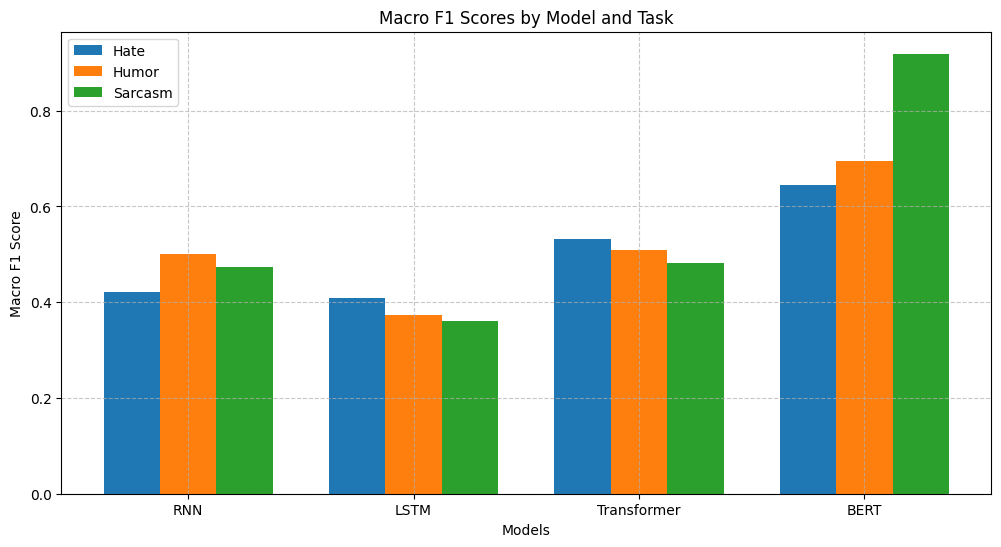

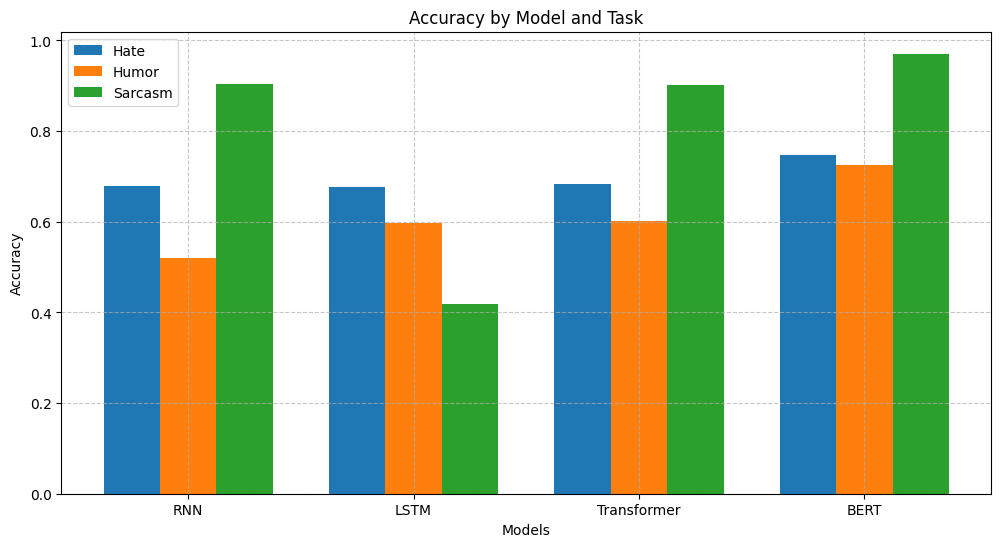

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Data from your reports (replace with your actual values)
tasks = ['Hate', 'Humor', 'Sarcasm']
models = ['RNN', 'LSTM', 'Transformer', 'BERT']

# Macro F1 scores (order: RNN, LSTM, Transformer, BERT for each task)
macro_f1 = {
    'Hate': [0.4211, 0.4098, 0.5319, 0.6441],
    'Humor': [0.5000, 0.3737, 0.5081, 0.6953],
    'Sarcasm': [0.4745, 0.3608, 0.4819, 0.9191]
}

# Accuracy (order: RNN, LSTM, Transformer, BERT for each task)
accuracy = {
    'Hate': [0.6796, 0.6761, 0.6823, 0.7484],
    'Humor': [0.5193, 0.5966, 0.6007, 0.7243],
    'Sarcasm': [0.9029, 0.4194, 0.9021, 0.9708]
}

# Plot Macro F1 Scores
plt.figure(figsize=(12, 6))
x = np.arange(len(models))
width = 0.25

for i, task in enumerate(tasks):
    plt.bar(x + i*width, macro_f1[task], width=width, label=task)

plt.xlabel('Models')
plt.ylabel('Macro F1 Score')
plt.title('Macro F1 Scores by Model and Task')
plt.xticks(x + width, models)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Plot Accuracy
plt.figure(figsize=(12, 6))
for i, task in enumerate(tasks):
    plt.bar(x + i*width, accuracy[task], width=width, label=task)

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy by Model and Task')
plt.xticks(x + width, models)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()